# بسم الله الرحمن الرحيم

In [1]:
from utils import *
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt 


2023-05-16 20:29:38.876033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 20:29:39.046563: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-16 20:29:39.046594: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-16 20:29:39.897227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
df = pd.read_csv("dataset/body_level_classification_train.csv")

In [3]:
df_original= cleaning_data(df).copy()

In [4]:
all_class_train,all_class_test=data_spliting(df_original,1/3)
## shuffling 
all_class_train = all_class_train.sample(frac=1.0, random_state=42)
all_class_test = all_class_test.sample(frac=1.0, random_state=42)

In [5]:
X_train=all_class_train.drop(["Body_Level"],axis=1).to_numpy()
Y_train=all_class_train["Body_Level"].to_numpy()
X_test =all_class_test.drop(["Body_Level"],axis=1).to_numpy()
Y_test =all_class_test["Body_Level"].to_numpy()

In [6]:
class_weights = all_class_train["Body_Level"].value_counts().to_dict()
total_num = sum(class_weights.values())
class_weights= { i : (total_num/(4* j )) for i ,j in zip(class_weights.keys(),class_weights.values())}

In [7]:
X_train, scaler= data_scaling(X_train)


In [8]:
X_val, X_test, Y_val, Y_test = train_test_split(X_test
                                                     , Y_test, test_size=0.5, random_state=42)

In [9]:
X_val = scaler.transform(X_val)
X_test=scaler.transform(X_test)

# Bare Logistic Regression 

In [10]:
bare_reg_model = LogisticRegression()
# concat the train and the val becuase it's the bare one 
bare_reg_model.fit(np.concatenate([X_train,X_val], axis=0)
                   ,np.concatenate([Y_train,Y_val],axis=0))

LogisticRegression()

## accuracy on test

In [11]:
bare_accuracy , repo = test_model(bare_reg_model,X_test,Y_test,axis=False)

In [12]:
print(bare_accuracy)

0.9512195121951219


In [13]:
print(repo)

              precision    recall  f1-score   support

           0       0.87      0.96      0.92        28
           1       0.96      0.72      0.83        36
           2       0.93      0.99      0.96        80
           3       0.99      1.00      1.00       102

    accuracy                           0.95       246
   macro avg       0.94      0.92      0.92       246
weighted avg       0.95      0.95      0.95       246



## applying the hyperpamater tuning 
**In this model we get the best we can get from the Logistic regression by applying the Tuning and get the best hyperparameters**

In [14]:

reg_model = LogisticRegression(random_state=42,max_iter=3000)
# Define the parameter grid to search over
param_grid = {
    'C': [0.001,0.01,0.1, 1, 10,100,200,300,400,500 ,600 ,700 ],
    'penalty': ['l2']
}


grid_search = GridSearchCV(estimator=reg_model, param_grid=param_grid,
                           cv=2,verbose=2)

# concat beacuase we use the K-Fold cross validation 
grid_search.fit(np.concatenate([X_train,X_val], axis=0)
                   ,np.concatenate([Y_train,Y_val],axis=0))



# Access the cv_results_ dictionary
cv_results = grid_search.cv_results_

# Print the mean test scores for each hyperparameter combination
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(params['C'], mean_score)



Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.1s
[CV] END ...................................C=10, penalty=l2; total time=   0.1s
[CV] END ..................................C=100, penalty=l2; total time=   0.2s
[CV] END ..................................C=100

In [15]:
best_reg_model = grid_search.best_estimator_

## accuracy on test on best reg model 

In [16]:
best_accuracy , repo = test_model(best_reg_model,X_test,Y_test,axis=False)

In [17]:
print(best_accuracy)
print(repo)

0.983739837398374
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.97      0.97      0.97        36
           2       1.00      0.97      0.99        80
           3       0.98      1.00      0.99       102

    accuracy                           0.98       246
   macro avg       0.98      0.98      0.98       246
weighted avg       0.98      0.98      0.98       246



## Plotting the change on accuracy tuning the 'C' hyperparameter

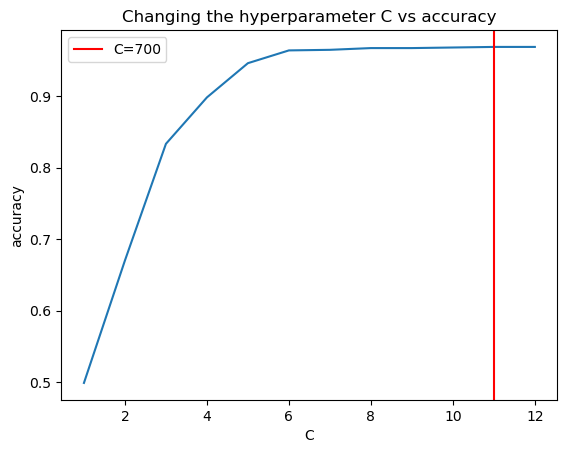

In [18]:
# Print the mean test scores for each hyperparameter combination
x_axis = []
y_axis = []
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    x_axis.append(params["C"])
    y_axis.append(mean_score)
    
    
plt.plot(np.arange(1,len(x_axis)+1),y_axis)
plt.title('Changing the hyperparameter C vs accuracy')
plt.xlabel('C')
plt.ylabel('accuracy')
plt.axvline(np.argmax(cv_results["mean_test_score"]),
            color='red',
            label=f"C={cv_results['params'][np.argmax(cv_results['mean_test_score'])]['C']}")
plt.legend()
plt.show()

## Regression model with class weights only 

In [19]:
only_weights_model = LogisticRegression(random_state=42,max_iter=3000
                                        ,class_weight=class_weights)



In [20]:
only_weights_model.fit(np.concatenate([X_train,X_val], axis=0)
                   ,np.concatenate([Y_train,Y_val],axis=0))

LogisticRegression(class_weight={0: 1.9409448818897639, 1: 1.8395522388059702,
                                 2: 0.9095940959409594, 3: 0.5429515418502202},
                   max_iter=3000, random_state=42)

In [21]:
only_weights_accuracy , repo = test_model(only_weights_model,X_test,Y_test,axis=False)

In [22]:
print(only_weights_accuracy)
print(repo)

0.967479674796748
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        28
           1       0.97      0.86      0.91        36
           2       0.96      0.99      0.98        80
           3       0.99      0.99      0.99       102

    accuracy                           0.97       246
   macro avg       0.96      0.95      0.95       246
weighted avg       0.97      0.97      0.97       246



## Regression model with best C only


In [23]:
only_C_model = LogisticRegression(random_state=42,max_iter=3000
                                        ,C=700)


In [24]:
only_C_model.fit(np.concatenate([X_train,X_val], axis=0)
                   ,np.concatenate([Y_train,Y_val],axis=0))

LogisticRegression(C=700, max_iter=3000, random_state=42)

In [25]:
only_C_accuracy , repo = test_model(only_C_model,X_test,Y_test,axis=False)

In [26]:
print(only_C_accuracy)
print(repo)

0.983739837398374
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.97      0.97      0.97        36
           2       1.00      0.97      0.99        80
           3       0.98      1.00      0.99       102

    accuracy                           0.98       246
   macro avg       0.98      0.98      0.98       246
weighted avg       0.98      0.98      0.98       246



**As shown from above analysis , it's obvious that the Tuning the Parameter C alone , or providing class_weights alone is much better that apply both of them**

# oversampling 

In [27]:
oversampled= over_sampling(all_class_train,sampling_ratio=0.5)

In [28]:
class_weights = oversampled["Body_Level"].value_counts().to_dict()
total_num = sum(class_weights.values())
class_weights= { i : (total_num/(4* j )) for i ,j in zip(class_weights.keys(),class_weights.values())}

In [29]:
class_weights

{3: 0.7252202643171806,
 2: 0.9571220930232558,
 1: 1.256679389312977,
 0: 1.2811284046692606}

In [30]:
X_train=oversampled.drop(["Body_Level"],axis=1).to_numpy()
Y_train=oversampled["Body_Level"].to_numpy()
X_test =all_class_test.drop(["Body_Level"],axis=1).to_numpy()
Y_test =all_class_test["Body_Level"].to_numpy()

In [31]:
X_train, scaler= data_scaling(X_train)
X_val, X_test, Y_val, Y_test = train_test_split(X_test
                                                     , Y_test, test_size=0.5, random_state=42)
X_val = scaler.transform(X_val)
X_test=scaler.transform(X_test)

## Applying the bare Regression on Oversampled data 

In [32]:
bare_oversampled_reg = LogisticRegression(max_iter=1000)
bare_oversampled_reg.fit(np.concatenate([X_train,X_val], axis=0)
                   ,np.concatenate([Y_train,Y_val],axis=0))

LogisticRegression(max_iter=1000)

In [33]:
bare_oversampled_accuracy , repo = test_model(bare_oversampled_reg,X_test,Y_test,axis=False)

In [34]:
print(bare_oversampled_accuracy)
print(repo)

0.975609756097561
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.97      0.92      0.94        36
           2       0.96      0.99      0.98        80
           3       0.99      0.99      0.99       102

    accuracy                           0.98       246
   macro avg       0.97      0.96      0.97       246
weighted avg       0.98      0.98      0.98       246



## Applying Regression On Over sampled data Class_weights only

In [35]:
oversampled_class_weights = LogisticRegression(max_iter=1000,class_weight=class_weights)
oversampled_class_weights.fit(np.concatenate([X_train,X_val], axis=0)
                   ,np.concatenate([Y_train,Y_val],axis=0))

LogisticRegression(class_weight={0: 1.2811284046692606, 1: 1.256679389312977,
                                 2: 0.9571220930232558, 3: 0.7252202643171806},
                   max_iter=1000)

In [36]:
oversampled_class_weights_accuracy , repo = test_model(oversampled_class_weights,X_test,
                                                       Y_test,axis=False)

In [37]:
print(oversampled_class_weights_accuracy)
print(repo)

0.975609756097561
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.97      0.92      0.94        36
           2       0.96      0.99      0.98        80
           3       0.99      0.99      0.99       102

    accuracy                           0.98       246
   macro avg       0.97      0.96      0.97       246
weighted avg       0.98      0.98      0.98       246



## Tuning the C value on oversampled data  

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score



reg_model = LogisticRegression(random_state=42,max_iter=3000)
# Define the parameter grid to search over
param_grid = {
    'C': [0.001,0.01,0.1, 1, 10,100,200,300,400,500 ,600 ,700,800,900,1000],
    'penalty': ['l2']
}


grid_search = GridSearchCV(estimator=reg_model, param_grid=param_grid, cv=5 , verbose=1 )

grid_search.fit(np.concatenate([X_train,X_val], axis=0)
                   ,np.concatenate([Y_train,Y_val],axis=0))



# Access the cv_results_ dictionary
cv_results = grid_search.cv_results_

# Print the mean test scores for each hyperparameter combination
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(params, mean_score)



Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [ ]:
Oversampled_C_only_accuracy , repo = test_model(grid_search.best_estimator_,
                                                X_test,Y_test,axis=False)

In [ ]:
print(Oversampled_C_only_accuracy)
print(repo)

## Plot the different values of C 

In [ ]:
x_axis = []
y_axis = []
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    x_axis.append(params["C"])
    y_axis.append(mean_score)
    
    
plt.plot(np.arange(1,len(x_axis)+1),y_axis)
plt.title('Changing the hyperparameter C vs accuracy')
plt.xlabel('C')
plt.ylabel('accuracy')
plt.axvline(np.argmax(cv_results["mean_test_score"]),
            color='red',
            label=f"C={cv_results['params'][np.argmax(cv_results['mean_test_score'])]['C']}")
plt.legend()
plt.show()

## Logistic Regression on best C and class weights on Oversampled data

In [ ]:
best_oversampled_class_weights = LogisticRegression(max_iter=1000,class_weight=class_weights,C=600)
best_oversampled_class_weights.fit(np.concatenate([X_train,X_val], axis=0)
                   ,np.concatenate([Y_train,Y_val],axis=0))

In [ ]:
best_oversampled_class_weights_accuracy , repo = test_model(best_oversampled_class_weights,
                                                            X_test,Y_test,axis=False)

In [ ]:
print(best_oversampled_class_weights_accuracy)
print(repo)

In [ ]:
with open("Best_Logistic_Regression_Model.h5","wb") as fb: 
            pickle.dump(best_oversampled_class_weights,fb)